In [13]:
cd /home/dmoi/projects/foldtree2

/home/dmoi/projects/foldtree2


In [14]:
#use autoreload 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Protein Structure Local Frame Analysis with Noise Robustness

This notebook demonstrates the extraction and analysis of local frames from a protein structure (PDB file), the conversion of rotation matrices to quaternions, and the evaluation of robustness to coordinate noise using FAPE and lDDT losses.

---

## Workflow Overview

1. **Setup and Data Extraction**
	- Change to the project directory.
	- Import required modules and classes.
	- Load a PDB file and extract coordinates for backbone atoms (N, CA, C).
	- Compute local frames (rotation matrices `R_true` and translations `t_true`).

2. **Quaternion Conversion**
	- Convert rotation matrices to quaternions (`quaternions`) for efficient representation and manipulation of rotations.

3. **Visualization**
	- Plot CA atom positions, local frames, and reconstructed global positions from the quaternion chain.

4. **Noise Robustness Experiment**
	- Add Gaussian noise to the coordinates (`noise_level = 0.5`).
	- Recompute local frames and quaternions for the noisy structure.
	- Visualize the effect of noise on CA positions, frames, and quaternion chain.

5. **Loss Evaluation**
	- Compute FAPE (Frame Aligned Point Error) loss between true and noisy frames (`fape`).
	- Compute lDDT (local Distance Difference Test) loss to assess structural similarity.

6. **Comparison Plot**
	- Overlay original and noisy CA coordinates for visual comparison.

---

## Key Variables

- **pdb_path**: Path to the input PDB file.
- **pdb2pyg**: Parser object for extracting coordinates and computing frames.
- **quaternions / quaternions_noisy**: Quaternion representations of local frames (original and noisy).
- **t_true / t_noisy**: Translation vectors for each residue (original and noisy).
- **fape**: FAPE loss value quantifying frame error due to noise.
- **noise_level**: Standard deviation of the Gaussian noise added to coordinates.

---

## Results

- The notebook visualizes how local frames and global positions change under coordinate noise.
- Quantitative metrics (FAPE and lDDT) provide insight into the structural impact of noise.
- The workflow can be adapted for benchmarking robustness of protein structure models or frame extraction algorithms.

In [16]:
import torch
from pdbgraph import PDB2PyG
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example PDB file path
pdb_path = './config/1eei.pdb'

# Initialize parser
pdb2pyg = PDB2PyG(aapropcsv = './config/aaindex1.csv')

# Extract coordinates for N, CA, C atoms (shape: N, 3, 3)
coords = torch.stack([
	pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="N"),
	pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="CA"),
	pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="C"),
], dim=1)

# Compute R (rotation matrices) and T (translations)
R_true, t_true = pdb2pyg.compute_local_frame(coords)

ImportError: attempted relative import with no known parent package

In [10]:
import numpy as np
def rotation_matrix_to_quaternion(R):
	"""
	Convert a batch of 3x3 rotation matrices to quaternions (x, y, z, w).
	R: (N, 3, 3)
	Returns: (N, 4)
	"""
	batch_size = R.shape[0]
	
	# Initialize output quaternions tensor
	q = torch.zeros((batch_size, 4), dtype=R.dtype, device=R.device)
	
	# Extract rotation matrix components
	m00, m01, m02 = R[:, 0, 0], R[:, 0, 1], R[:, 0, 2]
	m10, m11, m12 = R[:, 1, 0], R[:, 1, 1], R[:, 1, 2]
	m20, m21, m22 = R[:, 2, 0], R[:, 2, 1], R[:, 2, 2]
	
	# Compute trace of rotation matrix
	trace = m00 + m11 + m22
	
	# Case 1: trace > 0
	mask_trace_positive = trace > 0
	
	if mask_trace_positive.any():
		s = 2.0 * torch.sqrt(1.0 + trace[mask_trace_positive])
		q[mask_trace_positive, 3] = 0.25 * s
		q[mask_trace_positive, 0] = (m21 - m12)[mask_trace_positive] / s
		q[mask_trace_positive, 1] = (m02 - m20)[mask_trace_positive] / s
		q[mask_trace_positive, 2] = (m10 - m01)[mask_trace_positive] / s
	
	# Case 2: m00 > m11 and m00 > m22
	mask_m00_dominant = (~mask_trace_positive) & (m00 > m11) & (m00 > m22)
	
	if mask_m00_dominant.any():
		s = 2.0 * torch.sqrt(1.0 + m00[mask_m00_dominant] - m11[mask_m00_dominant] - m22[mask_m00_dominant])
		q[mask_m00_dominant, 0] = 0.25 * s
		q[mask_m00_dominant, 1] = (m01 + m10)[mask_m00_dominant] / s
		q[mask_m00_dominant, 2] = (m02 + m20)[mask_m00_dominant] / s
		q[mask_m00_dominant, 3] = (m21 - m12)[mask_m00_dominant] / s
	
	# Case 3: m11 > m22
	mask_m11_dominant = (~mask_trace_positive) & (~mask_m00_dominant) & (m11 > m22)
	
	if mask_m11_dominant.any():
		s = 2.0 * torch.sqrt(1.0 + m11[mask_m11_dominant] - m00[mask_m11_dominant] - m22[mask_m11_dominant])
		q[mask_m11_dominant, 1] = 0.25 * s
		q[mask_m11_dominant, 0] = (m01 + m10)[mask_m11_dominant] / s
		q[mask_m11_dominant, 2] = (m12 + m21)[mask_m11_dominant] / s
		q[mask_m11_dominant, 3] = (m02 - m20)[mask_m11_dominant] / s
	
	# Case 4: remaining cases (m22 is largest)
	mask_other = (~mask_trace_positive) & (~mask_m00_dominant) & (~mask_m11_dominant)
	
	if mask_other.any():
		s = 2.0 * torch.sqrt(1.0 + m22[mask_other] - m00[mask_other] - m11[mask_other])
		q[mask_other, 2] = 0.25 * s
		q[mask_other, 0] = (m02 + m20)[mask_other] / s
		q[mask_other, 1] = (m12 + m21)[mask_other] / s
		q[mask_other, 3] = (m10 - m01)[mask_other] / s
	
	# Normalize quaternions
	q = q / torch.norm(q, dim=1, keepdim=True)
	
	return q

def quaternion_to_rotation_matrix(quats):
	"""
	Convert a batch of unit quaternions (x, y, z, w) to rotation matrices.
	quats: (N, 4)
	Returns: (N, 3, 3)
	"""
	q = quats
	x, y, z, w = q[:,0], q[:,1], q[:,2], q[:,3]
	# Normalize to ensure unit quaternion
	norm = torch.sqrt(x**2 + y**2 + z**2 + w**2)
	x, y, z, w = x/norm, y/norm, z/norm, w/norm

	xx = x * x
	yy = y * y
	zz = z * z
	ww = w * w
	xy = x * y
	xz = x * z
	xw = x * w
	yz = y * z
	yw = y * w
	zw = z * w

	R = torch.stack([
		torch.stack([1-2*(yy+zz), 2*(xy-zw),   2*(xz+yw)], dim=-1),
		torch.stack([2*(xy+zw),   1-2*(xx+zz), 2*(yz-xw)], dim=-1),
		torch.stack([2*(xz-yw),   2*(yz+xw),   1-2*(xx+yy)], dim=-1)
	], dim=-2)  # shape (N, 3, 3)
	return R

In [11]:
quaternions = rotation_matrix_to_quaternion(R_true)

NameError: name 'R_true' is not defined

In [ ]:
def plot_points(coords, title="3D Points"):
	coords = coords.detach().cpu().numpy()
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(coords[:,0], coords[:,1], coords[:,2], c='b')
	#daw lines between points
	for i in range(len(coords)-1):
		ax.plot([coords[i,0], coords[i+1,0]], [coords[i,1], coords[i+1,1]], [coords[i,2], coords[i+1,2]], c='r')
	ax.set_title(title)
	plt.show()

def plot_reconstructed_chain(R, T, title="Reconstructed Chain"):
	R = R.detach().cpu().numpy()
	T = T.detach().cpu().numpy()
	# Convert rotation matrices to quaternions
	quats = rotation_matrix_to_quaternion(torch.tensor(R)).detach().cpu().numpy()
	# Convert quaternions and translations to global positions
	from src.losses.losses import compute_chain_positions
	positions = compute_chain_positions(quats, T)
	plot_points(positions, title)

def plot_quaternion_chain(quats, Ts, title="Quaternion Chain"):
	# Convert quaternions and translations to global positions
	from src.losses.losses import compute_chain_positions
	positions = compute_chain_positions(quats, Ts)
	plot_points(positions, title)

In [3]:
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import procrustes

def align_and_display_point_clouds(points1, points2, title="Point Cloud Alignment", 
								  colors=('blue', 'red'), labels=('Set 1', 'Set 2'),
								  connectpoints=True, alpha=(1.0, 0.8)):
	"""
	Align two point clouds using Kabsch algorithm and display them in a 3D plot.
	
	Args:
		points1 (torch.Tensor or numpy.ndarray): First point cloud of shape (N, 3)
		points2 (torch.Tensor or numpy.ndarray): Second point cloud of shape (N, 3)
		title (str): Plot title
		colors (tuple): Colors for the two point clouds
		labels (tuple): Labels for the two point clouds in the legend
		connectpoints (bool): Whether to connect points with lines
		alpha (tuple): Alpha transparency values for both point clouds
		
	Returns:
		float: RMSD between aligned point clouds
	"""
	import matplotlib.pyplot as plt
	
	# Convert to numpy if needed
	if isinstance(points1, torch.Tensor):
		points1_np = points1.detach().cpu().numpy()
	else:
		points1_np = np.array(points1)
		
	if isinstance(points2, torch.Tensor):
		points2_np = points2.detach().cpu().numpy()
	else:
		points2_np = np.array(points2)
	
	# Perform Procrustes analysis to align the point clouds
	# This translates, rotates, and scales the second point cloud to match the first
	mtx1, mtx2, disparity = procrustes(points1_np, points2_np)
	
	# Create 3D plot
	fig = plt.figure(figsize=(10, 8))
	ax = fig.add_subplot(111, projection='3d')
	
	# Plot first point cloud
	ax.scatter(mtx1[:, 0], mtx1[:, 1], mtx1[:, 2], c=colors[0], label=labels[0], alpha=alpha[0])
	if connectpoints:
		for i in range(len(mtx1)-1):
			ax.plot([mtx1[i, 0], mtx1[i+1, 0]], 
					[mtx1[i, 1], mtx1[i+1, 1]], 
					[mtx1[i, 2], mtx1[i+1, 2]], 
					c=colors[0], alpha=alpha[0]*0.6)
	
	# Plot second point cloud (aligned)
	ax.scatter(mtx2[:, 0], mtx2[:, 1], mtx2[:, 2], c=colors[1], label=labels[1], alpha=alpha[1])
	if connectpoints:
		for i in range(len(mtx2)-1):
			ax.plot([mtx2[i, 0], mtx2[i+1, 0]], 
					[mtx2[i, 1], mtx2[i+1, 1]], 
					[mtx2[i, 2], mtx2[i+1, 2]], 
					c=colors[1], alpha=alpha[1]*0.6)
	
	# Calculate RMSD
	rmsd = np.sqrt(np.mean(np.sum((mtx1 - mtx2)**2, axis=1)))
	
	ax.set_title(f"{title}\nRMSD: {rmsd:.4f}")
	ax.set_xlabel('X')
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	ax.legend()
	
	# Set equal aspect ratio
	max_range = np.array([
		mtx1[:, 0].max() - mtx1[:, 0].min(),
		mtx1[:, 1].max() - mtx1[:, 1].min(),
		mtx1[:, 2].max() - mtx1[:, 2].min(),
		mtx2[:, 0].max() - mtx2[:, 0].min(),
		mtx2[:, 1].max() - mtx2[:, 1].min(),
		mtx2[:, 2].max() - mtx2[:, 2].min(),
	]).max() / 2.0
	
	mid_x = (mtx1[:, 0].mean() + mtx2[:, 0].mean()) / 2
	mid_y = (mtx1[:, 1].mean() + mtx2[:, 1].mean()) / 2
	mid_z = (mtx1[:, 2].mean() + mtx2[:, 2].mean()) / 2
	
	ax.set_xlim(mid_x - max_range, mid_x + max_range)
	ax.set_ylim(mid_y - max_range, mid_y + max_range)
	ax.set_zlim(mid_z - max_range, mid_z + max_range)
	
	plt.tight_layout()
	plt.show()
	
	return rmsd

In [5]:
# Plot CA coordinates
ca_coords = pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="CA")
plot_points(ca_coords, "CA Atoms")

# Plot frames (R, T)
#plot_transforms(R_true, t_true, "Local Frames")

# Plot global positions from quaternion chain
plot_quaternion_chain(quaternions, t_true, "Quaternion Chain Positions")

NameError: name 'pdb2pyg' is not defined

tensor([[ -2.5580,   0.6100,  -2.7700],
        [ -6.3293,   0.3099,  -2.9196],
        [ -6.3830,   1.0165,  -6.6222],
        [ -8.3479,   2.3294,  -3.6401],
        [ -6.7864,  -0.6379,  -5.4002],
        [ -9.0025,   2.0589,  -4.0301],
        [-12.5953,   3.0686,  -3.2905],
        [-16.1457,   4.3031,  -2.8167],
        [-18.3886,   1.9135,  -4.7329],
        [-17.1919,   4.9792,  -6.6541],
        [-17.0383,   8.4675,  -8.1591],
        [-14.0693,   9.6151, -10.1822],
        [-15.6079,  11.5478, -13.0677],
        [-19.0491,  10.1822, -13.0604],
        [-18.3910,   8.9235, -16.5343],
        [-17.6321,  10.4667, -19.8558],
        [-21.1655,  10.1997, -18.5245],
        [-23.6312,  12.9528, -17.7851],
        [-22.4319,  12.8992, -21.3588],
        [-25.8529,  11.4385, -22.1784],
        [-26.6080,  10.0522, -18.7196],
        [-27.4765,   8.0346, -21.8411],
        [-28.1931,   8.2011, -25.5778],
        [-27.8977,   6.6619, -22.1222],
        [-31.1597,   8.5234, -21.5812],


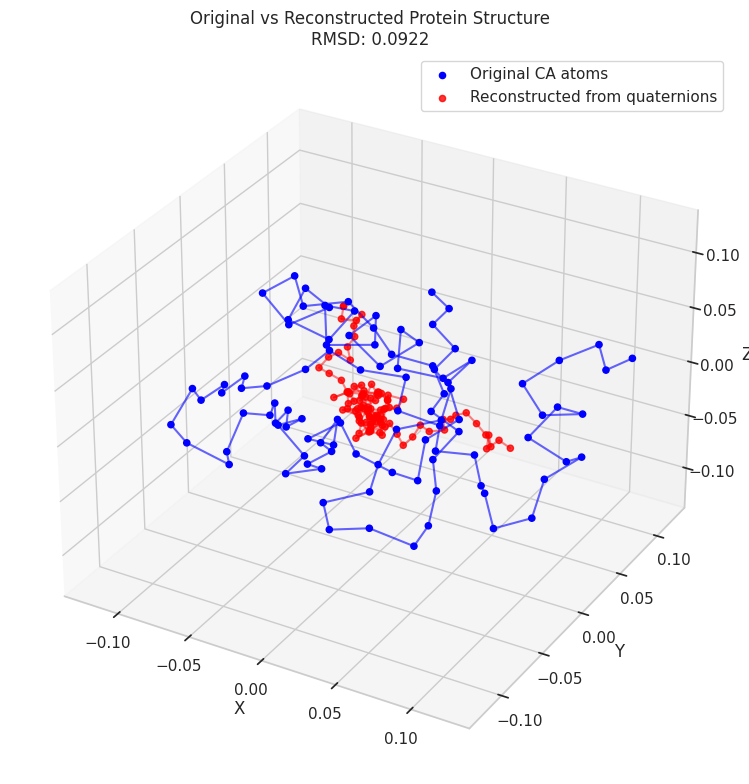

RMSD between original and reconstructed structures: 0.0922 Å


In [52]:
from src.losses.losses import compute_chain_positions

# Extract original CA coordinates
ca_coords = pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="CA")

# Compute global positions from quaternion chain
reconstructed_coords = compute_chain_positions(quaternions, t_true)

print(reconstructed_coords)
# Use the alignment and visualization function to compare the two structures
rmsd = align_and_display_point_clouds(
	ca_coords, 
	reconstructed_coords,
	title="Original vs Reconstructed Protein Structure",
	colors=('blue', 'red'),
	labels=('Original CA atoms', 'Reconstructed from quaternions'),
	connectpoints=True,
	alpha=(1.0, 0.8)
)


print(f"RMSD between original and reconstructed structures: {rmsd:.4f} Å")


In [ ]:

# Calculate per-residue deviation
deviations = torch.norm(ca_coords - reconstructed_coords, dim=1)
max_dev = deviations.max().item()
avg_dev = deviations.mean().item()
print(f"Average deviation: {avg_dev:.4f} Å")
print(f"Maximum deviation: {max_dev:.4f} Å")

# Optionally, plot the per-residue deviation
plt.figure(figsize=(10, 6))
plt.plot(deviations.detach().cpu().numpy())
plt.axhline(y=avg_dev, color='r', linestyle='--', label=f'Avg: {avg_dev:.4f} Å')
plt.xlabel('Residue index')
plt.ylabel('Deviation (Å)')
plt.title('Per-residue deviation between original and reconstructed structures')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

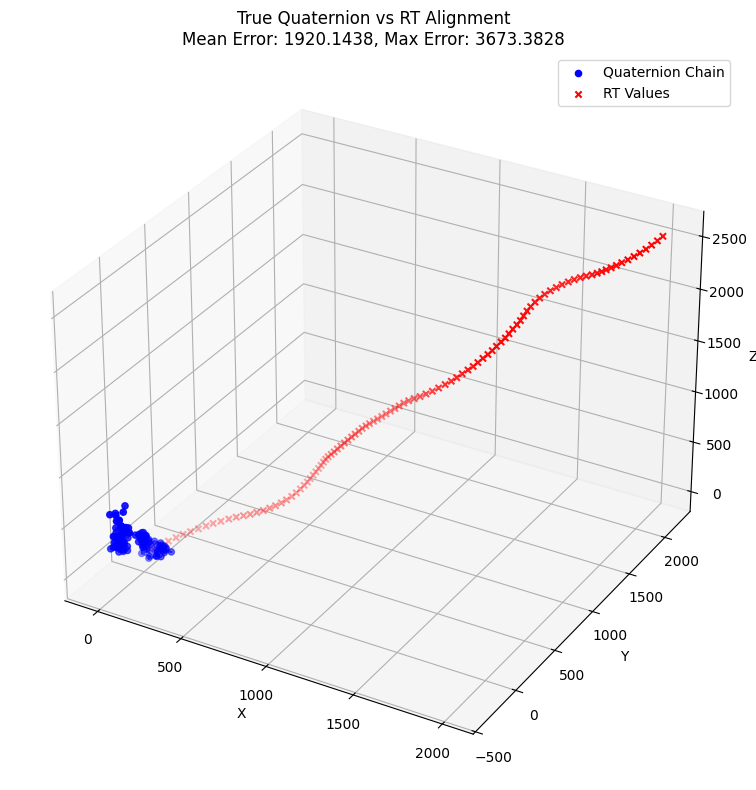

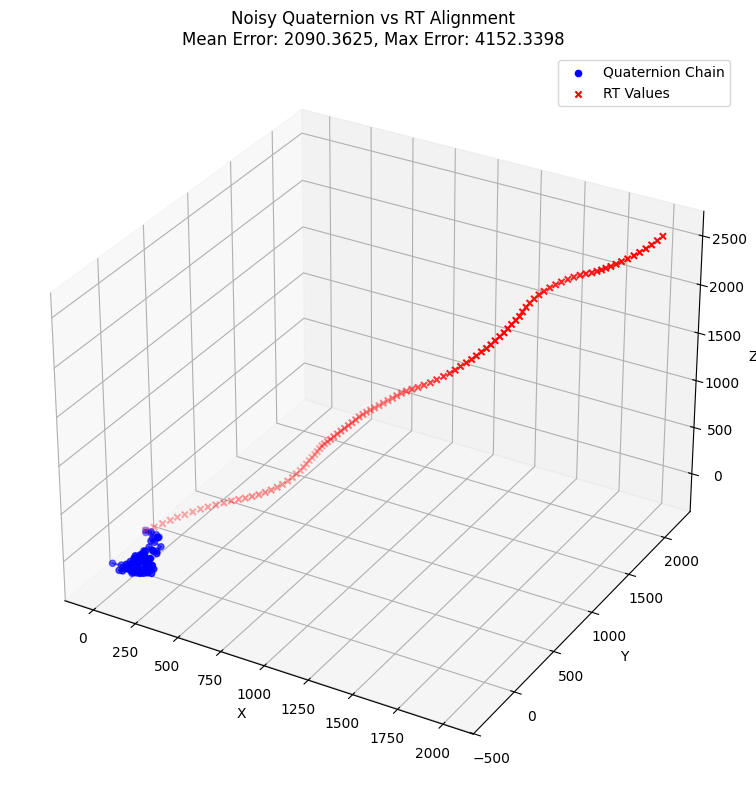

True data - Mean error: 1920.1438, Max error: 3673.3828
Noisy data - Mean error: 2090.3625, Max error: 4152.3398


In [ ]:
from src.losses.losses import compute_chain_positions

def plot_quaternion_and_rt_alignment(quats, translations, R, T, title="Alignment Plot"):
	"""
	Plot points created from quaternion chain and from RT values to check alignment.
	
	Args:
		quats (torch.Tensor): Quaternions (N, 4)
		translations (torch.Tensor): Translations (N, 3)
		R (torch.Tensor): Rotation matrices (N, 3, 3)
		T (torch.Tensor): Translation vectors (N, 3)
		title (str): Plot title
	"""
	# Get positions from quaternion chain
	quat_positions = compute_chain_positions(quats, translations)
	
	# Get positions from RT directly
	# Start with origin for first residue
	rt_positions = torch.zeros_like(T)
	global_pos = torch.zeros(3, dtype=T.dtype, device=T.device)
	
	
	# Convert to numpy for plotting
	quat_pos_np = quat_positions.detach().cpu().numpy()
	rt_pos_np = rt_positions.detach().cpu().numpy()
	
	# Create 3D plot
	fig = plt.figure(figsize=(10, 8))
	ax = fig.add_subplot(111, projection='3d')
	
	# Plot quaternion-derived positions
	ax.scatter(quat_pos_np[:, 0], quat_pos_np[:, 1], quat_pos_np[:, 2], 
			   c='blue', marker='o', label='Quaternion Chain')
	
	# Plot RT-derived positions
	ax.scatter(rt_pos_np[:, 0], rt_pos_np[:, 1], rt_pos_np[:, 2], 
			   c='red', marker='x', label='RT Values')
	
	# Draw lines for quaternion chain
	for i in range(len(quat_pos_np)-1):
		ax.plot([quat_pos_np[i, 0], quat_pos_np[i+1, 0]], 
				[quat_pos_np[i, 1], quat_pos_np[i+1, 1]], 
				[quat_pos_np[i, 2], quat_pos_np[i+1, 2]], 
				c='blue', alpha=0.5)
	
	# Calculate alignment error
	error = torch.norm(quat_positions - rt_positions, dim=1)
	mean_error = error.mean().item()
	max_error = error.max().item()
	
	ax.set_title(f"{title}\nMean Error: {mean_error:.4f}, Max Error: {max_error:.4f}")
	ax.set_xlabel('X')
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	ax.legend()
	
	plt.tight_layout()
	plt.show()
	
	return mean_error, max_error

# Plot alignment for true data
true_error_mean, true_error_max = plot_quaternion_and_rt_alignment(
	quaternions, t_true, R_true, t_true, "True Quaternion vs RT Alignment")

# Plot alignment for noisy data
noisy_error_mean, noisy_error_max = plot_quaternion_and_rt_alignment(
	quaternions_noisy, t_noisy, R_noisy, t_noisy, "Noisy Quaternion vs RT Alignment")

print(f"True data - Mean error: {true_error_mean:.4f}, Max error: {true_error_max:.4f}")
print(f"Noisy data - Mean error: {noisy_error_mean:.4f}, Max error: {noisy_error_max:.4f}")

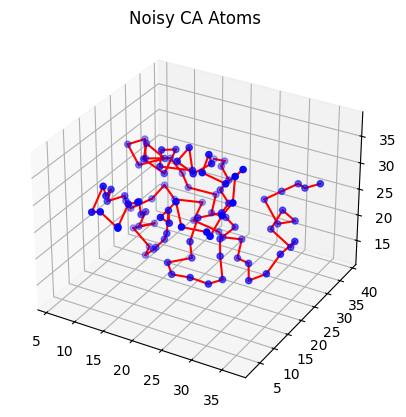

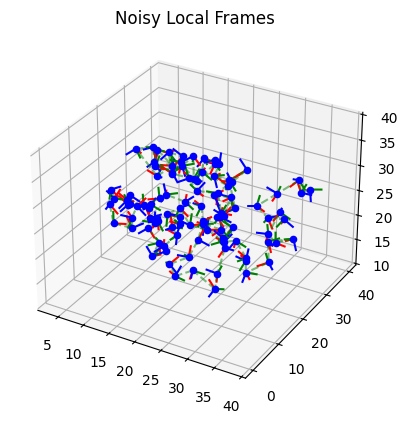

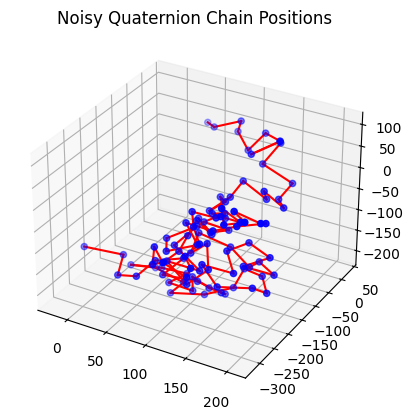

FAPE loss (noisy vs. true): 7.672886848449707


RuntimeError: The size of tensor a (103) must match the size of tensor b (3) at non-singleton dimension 2

In [27]:
# Add noise to the coordinates
noise_level = 0.5  # adjust as needed
coords_noisy = coords + torch.randn_like(coords) * noise_level

# Recompute R and T for noisy coordinates
R_noisy, t_noisy = pdb2pyg.compute_local_frame(coords_noisy)

# Convert noisy R to quaternions
quaternions_noisy = rotation_matrix_to_quaternion(R_noisy)

# Plot noisy CA coordinates
ca_coords_noisy = pdb2pyg.extract_pdb_coordinates(pdb_path, atom_type="CA") + torch.randn_like(ca_coords) * noise_level
plot_points(ca_coords_noisy, "Noisy CA Atoms")

# Plot noisy frames
plot_transforms(R_noisy, t_noisy, "Noisy Local Frames")

# Plot noisy quaternion chain
plot_quaternion_chain(quaternions_noisy, t_noisy, "Noisy Quaternion Chain Positions")

# --- Compute FAPE loss and lDDT loss ---
from src.losses.losses import fape_loss, lddt_loss

# FAPE loss (using original as true, noisy as pred)
batch = torch.zeros(coords.shape[0], dtype=torch.long)  # single batch
fape = fape_loss(R_true, t_true, R_noisy, t_noisy, batch)
print("FAPE loss (noisy vs. true):", fape.item())

# lDDT loss (using original as true, noisy as pred)
lddt = lddt_loss(ca_coords, R_noisy, t_noisy, batch)
print("lDDT loss (noisy vs. true):", lddt.item())

In [ ]:
# Plot original and noisy CA coordinates together for comparison
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ca_coords[:,0], ca_coords[:,1], ca_coords[:,2], c='b', label='Original CA')
ax.scatter(ca_coords_noisy[:,0], ca_coords_noisy[:,1], ca_coords_noisy[:,2], c='r', alpha=0.6, label='Noisy CA')
ax.set_title("Original vs Noisy CA Atoms")
ax.legend()
plt.show()